In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [2]:
t_normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
t_horizflip = transforms.RandomHorizontalFlip()
t_crop = transforms.RandomCrop(32, padding=4, padding_mode='reflect')

transform = transforms.Compose([transforms.ToTensor(), t_normalize])
augment = transforms.Compose([t_horizflip, t_crop, 
                              transforms.ToTensor(), t_normalize])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=augment)
trainset, valset = torch.utils.data.random_split(trainset, [0.98, 0.02])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class ResNet_block(nn.Module):
  def __init__(self, in_ch, out_ch, kernel=3, stride=1, skip=None):
    super(ResNet_block, self).__init__()
    self.skip = skip
    pad = (kernel-1)//2
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride, padding=pad, bias=False)
    self.bn1 = nn.BatchNorm2d(out_ch)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=kernel, stride=1, padding=pad, bias=False)
    self.bn2 = nn.BatchNorm2d(out_ch)
    self.relu2 = nn.ReLU(inplace=True)

  def forward(self, x):
    # print("input", x.shape)
    y = self.conv1(x)
    y = self.bn1(y)
    # print("at conv1", y.shape)
    y = self.relu1(y)
    y = self.conv2(y)
    y = self.bn2(y)
    # print("at conv2", y.shape)
    if self.skip:
      # If skip==None, skip is Identity
      x = self.skip(x)

    y += x
    y = self.relu2(y)
    return y

class ResNet_skip(nn.Module):
  def __init__(self, in_ch, out_ch, stride=1):
    super(ResNet_skip, self).__init__()
    self.pool = nn.MaxPool2d(kernel_size=stride, stride=stride)
    self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=False)
    self.bn = nn.BatchNorm2d(out_ch)
    
  def forward(self, x):
    y = self.pool(x)
    y = self.conv(y)
    y = self.bn(y)
    return y

class ResNet18(nn.Module):
  def __init__(self, layer_channels, num_classes=10):
    super(ResNet18, self).__init__()
    
    lc_input, lc1, lc2, lc3, lc4, lc5 = layer_channels
    self.conv1 = nn.Sequential(nn.Conv2d(lc_input, lc1, kernel_size=3, stride=2, padding=1, bias=False), nn.BatchNorm2d(lc1), nn.ReLU(inplace=True))

    self.layer1 = nn.Sequential(ResNet_block(lc1, lc1), ResNet_block(lc1, lc1))
    skip2 = ResNet_skip(lc1, lc2, stride=2)
    self.layer2 = nn.Sequential(ResNet_block(lc1, lc2, stride=2, skip=skip2), ResNet_block(lc2, lc2))
    skip3 = ResNet_skip(lc2, lc3, stride=2)
    self.layer3 = nn.Sequential(ResNet_block(lc2, lc3, stride=2, skip=skip3), ResNet_block(lc3, lc3))
    skip4 = ResNet_skip(lc3, lc4, stride=2)
    self.layer4 = nn.Sequential(ResNet_block(lc3, lc4, stride=2, skip=skip4), ResNet_block(lc4, lc4))
    skip5 = ResNet_skip(lc4, lc5, stride=2)
    self.layer5 = nn.Sequential(ResNet_block(lc4, lc5, stride=2, skip=skip5), ResNet_block(lc5, lc5))

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(lc5, num_classes)

  def forward(self, x):
    # print("input", x.shape)
    y = self.conv1(x)
    # print("after inp conv", y.shape)
    y = self.layer1(y)
    y = self.layer2(y)
    y = self.layer3(y)
    y = self.layer4(y)
    y = self.layer5(y)

    y = self.avgpool(y)
    y = torch.squeeze(y)
    y = self.fc(y)

    return y

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = ResNet18([3, 64, 128, 144, 192, 256])
model = model.to(device)

print('full', sum(p.numel() for p in model.parameters() if p.requires_grad))
print('conv1', sum(p.numel() for p in model.conv1.parameters() if p.requires_grad))
print('layer1', sum(p.numel() for p in model.layer1.parameters() if p.requires_grad))
print('layer2', sum(p.numel() for p in model.layer2.parameters() if p.requires_grad))
print('layer3', sum(p.numel() for p in model.layer3.parameters() if p.requires_grad))
print('layer4', sum(p.numel() for p in model.layer4.parameters() if p.requires_grad))
print('layer5', sum(p.numel() for p in model.layer5.parameters() if p.requires_grad))
print('fc', sum(p.numel() for p in model.fc.parameters() if p.requires_grad))

epochs = 100
max_lr = 0.01
grad_clip = 0.1 # put None for 0
weight_decay = 1e-4
learning_rate = 0.001
opt_func = torch.optim.Adam
# opt_func = torch.optim.SGD
# momentum=0.9

criterion = nn.CrossEntropyLoss()
optimizer = opt_func(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# lr_sched = None
# lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, verbose=True)
lr_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(trainloader), epochs=epochs)
# lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001, verbose=True)

cuda:0
full 4960874
conv1 1856
layer1 147968
layer2 525568
layer3 745632
layer4 1273728
layer5 2263552
fc 2570


In [5]:
def train_loop(model, dataset, optimizer, criterion, device, lr_sched=None, grad_clip=None):
  total_loss = 0.0
  accurate = 0
  model.train()

  for i, data in enumerate(dataset):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    # gradient clipping
    if grad_clip:
      nn.utils.clip_grad_value_(model.parameters(), grad_clip)
    optimizer.step()

    # learning scheduler update
    if lr_sched:
      lr_sched.step()
    
    # Accuracy
    probs = torch.softmax(outputs, 1)
    preds = torch.argmax(probs, 1)
    # print(probs.cpu(), preds.cpu(), labels.cpu())
    count = sum(preds == labels)
    accurate += count.item() / labels.shape[0]

    total_loss += loss.item()
  
  return total_loss / len(dataset), accurate / len(dataset)

def eval_loop(model, dataset, criterion, device):
  total_loss = 0.0
  accurate = 0
  model.eval()
  with torch.no_grad():
    for data in dataset:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      
      # Run the model forwards
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      total_loss += loss.item()

      # Accuracy
      probs = torch.softmax(outputs, 1)
      preds = torch.argmax(probs, 1)
      # print(probs.cpu(), preds.cpu(), labels.cpu())
      count = sum(preds == labels)
      accurate += count.item() / labels.shape[0]

  return total_loss / len(dataset), accurate / len(dataset)

In [ ]:
best_val_loss = float('inf')
best_val_acc = 0
train_loss_list, train_acc_list, val_loss_list, val_acc_list = list(), list(), list(), list()
for epoch in range(epochs):  # loop over the dataset multiple times
  train_loss, train_acc = train_loop(model, trainloader, optimizer, criterion, device, lr_sched, grad_clip)

  val_loss, val_acc = eval_loop(model, valloader, criterion, device)
  print(f'Epoch:{epoch} train:[{train_loss:.3E}, {train_acc*100:.2f}%] val:[{val_loss:.3E}, {val_acc*100:.2f}%])') 
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc*100)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc*100)
  if val_loss < best_val_loss or val_acc > best_val_acc:
    print("## BEST")
    best_val_loss = min(val_loss, best_val_loss)
    best_val_acc = max(val_acc, best_val_acc)
    torch.save(model.state_dict(), 'best_model.pt')

print('Finished Training')

model.load_state_dict(torch.load('best_model.pt'))
loss, acc = eval_loop(model, testloader, criterion, device)
print(f'Test:[{loss:.3E}, {acc*100:.2f}%]')

Epoch:0 train:[1.539E+00, 43.72%] val:[1.405E+00, 48.05%])
## BEST
Epoch:1 train:[1.148E+00, 58.79%] val:[1.080E+00, 61.89%])
## BEST
Epoch:2 train:[9.677E-01, 65.49%] val:[1.025E+00, 64.17%])
## BEST
Epoch:3 train:[8.463E-01, 70.10%] val:[1.034E+00, 65.77%])
## BEST
Epoch:4 train:[7.621E-01, 73.22%] val:[9.216E-01, 69.23%])
## BEST
Epoch:5 train:[7.009E-01, 75.60%] val:[8.237E-01, 70.87%])
## BEST
Epoch:6 train:[6.539E-01, 77.11%] val:[8.205E-01, 70.58%])
## BEST
Epoch:7 train:[6.295E-01, 78.02%] val:[7.948E-01, 71.98%])
## BEST
Epoch:8 train:[6.016E-01, 78.98%] val:[7.172E-01, 73.06%])
## BEST
Epoch:9 train:[5.612E-01, 80.57%] val:[6.661E-01, 76.90%])
## BEST
Epoch:10 train:[5.384E-01, 81.27%] val:[6.476E-01, 77.05%])
## BEST
Epoch:11 train:[5.194E-01, 82.03%] val:[6.217E-01, 78.34%])
## BEST
Epoch:12 train:[5.100E-01, 82.41%] val:[6.625E-01, 77.99%])
Epoch:13 train:[4.996E-01, 82.80%] val:[7.004E-01, 75.45%])
Epoch:14 train:[4.882E-01, 83.25%] val:[7.253E-01, 75.59%])
Epoch:15 train

In [12]:
model.load_state_dict(torch.load('best_model.pt'))
loss, acc = eval_loop(model, testloader, criterion, device)
print(f'Test:[{loss:.3E}, {acc*100:.2f}%]')

Test:[2.884E-01, 91.01%]


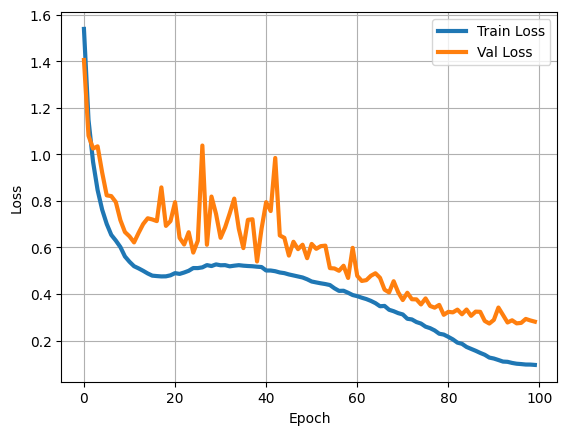

In [13]:

# importing package
import matplotlib.pyplot as plt
  
def plot_loss(train_loss_history, valid_loss_history):
  plt.plot(range(epochs),train_loss_history,'-',linewidth=3,label='Train Loss') 
  plt.plot(range(epochs),valid_loss_history,'-',linewidth=3,label='Val Loss') 
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend() 
  plt.grid(True)
  plt.show()

plot_loss(train_loss_list, val_loss_list)

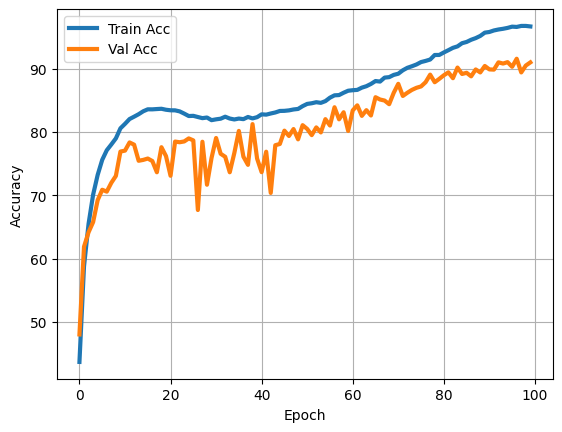

In [14]:
def plot_acc(train_acc_history, valid_acc_history):
  plt.plot(range(epochs),train_acc_history,'-',linewidth=3,label='Train Acc') 
  plt.plot(range(epochs),valid_acc_history,'-',linewidth=3,label='Val Acc') 
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend() 
  plt.grid(True)
  plt.show()
plot_acc(train_acc_list, val_acc_list)

In [17]:
import numpy as np
np.save('train_loss.npy', train_loss_list)
np.save('train_acc.npy', train_acc_list)
np.save('valid_loss.npy', val_loss_list)
np.save('valid_acc.npy', val_acc_list)